### Author: Hoang Chu

### Imports

In [16]:
%pip install -r dependencies.txt


[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [17]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import requests
import scipy
import importlib
import helper, consts
importlib.reload(consts)
importlib.reload(helper)
import glob

### CONSTANTS

In [18]:
ROW = consts.ROW
COL = consts.COL
RAW_DATA_PATH = consts.RAW_DATA_PATH
RESPONSE_NAME = consts.RESPONSE_NAME

RESPONSE_NAME

'tonight'

### Quick Functions

In [19]:
does_sub_df_has_Nan = lambda df, col_name: df[[col_name]].isna().any(axis=COL)

### Read data

In [20]:
testday = '20170103'

trainRange = helper.get_train_from_testday(testday)
training_range = f"{trainRange[0]}-{trainRange[1]}"
files = helper.get_file_names(trainRange[0],trainRange[1]) # get filenames from before 6/1/2015

In [21]:
# local read

# take in testing day - split into year and month 

dfs = [pd.read_csv(consts.RAW_DATA_PATH + f"{f}") for f in files]
main_df = pd.concat(dfs)

testfile = f"data.{testday}_1200.csv"
test_df = pd.read_csv(consts.RAW_DATA_PATH + testfile)

x_cols = ["rrirpnxm_nt_0", "rrirpnxm_lst15_0","rrirpnxm_lsthrx15_0", "rrirpnxm_toxhr_0"]
saved_cols = x_cols + [RESPONSE_NAME]

# training_df and testing_df are the result of selecting necessary columns from 
# main_df (concatenated training files) and test_df
training_df = main_df[saved_cols]
testing_df = test_df[saved_cols]



### Feature Selection

##### Preliminary check

In [22]:
main_df.shape

(758878, 252)

In [23]:
test_df.shape

(3022, 252)

In [24]:
print(f"{training_range}:")
main_df.info()
print(f"Columns with NaN: {main_df[main_df.isna().any(axis=COL)]}")

print()

print(f"{testday}:")
test_df.info()
print(f"Columns with NaN: {test_df[test_df.isna().any(axis=COL)]}")

20151101-20161101:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 758878 entries, 0 to 2978
Columns: 252 entries, eqid to tr_toxhr_0
dtypes: float64(251), int64(1)
memory usage: 1.4 GB
Columns with NaN: Empty DataFrame
Columns: [eqid, wt, today, tonight, tmwam, dn3sttmwmd, dn1, dn4x1, cftorrrelstd_open_0, liqlog_open_0, llirpnxm_am_1, llirpnxm_dy_12to16, llirpnxm_dy_17to21, llirpnxm_dy_1to3, llirpnxm_dy_4to6, llirpnxm_dy_7to11, llirpnxm_lst15_0, llirpnxm_lsthrx15_0, llirpnxm_md_1, llirpnxm_nt_0, llirpnxm_nt_1, llirpnxm_nt_12to16, llirpnxm_nt_17to21, llirpnxm_nt_1to3, llirpnxm_nt_4to6, llirpnxm_nt_7to11, llirpnxm_pm_1, llirpnxm_toxhr_0, mocrelvol_open_1, mocrelvol_open_13to17, mocrelvol_open_18to22, mocrelvol_open_2to4, mocrelvol_open_5to7, mocrelvol_open_8to12, momr10d_open_0, momr50dx10d_open_0, moorelvol_open_0, moorelvol_open_12to16, moorelvol_open_17to21, moorelvol_open_1to3, moorelvol_open_4to6, moorelvol_open_7to11, nnetticksrelmultstdev_am_1, nnetticksrelmultstdev_dy_12to16, 

In [25]:
print(f"{training_range} - unique eqid count: {main_df.eqid.nunique()}")
print(f"{testday} - unique eqid count: {test_df.eqid.nunique()}")

20151101-20161101 - unique eqid count: 3474
20170103 - unique eqid count: 3022


In [26]:
main_df.drop('eqid', axis=COL, inplace=True)
test_df.drop('eqid', axis=COL, inplace=True)

In [27]:
print(f"training set {training_range}:")
main_df.describe().loc[['min', 'max']]

training set 20151101-20161101:


,wt,today,tonight,tmwam,dn3sttmwmd,dn1,dn4x1,cftorrrelstd_open_0,liqlog_open_0,llirpnxm_am_1,...,tr_md_1,tr_nt_0,tr_nt_1,tr_nt_12to16,tr_nt_17to21,tr_nt_1to3,tr_nt_4to6,tr_nt_7to11,tr_pm_1,tr_toxhr_0
min,0.000014,-0.098567,-0.153147,-0.154224,-0.399354,-0.261471,-0.392193,-1.898721,-3.537791,-0.053295,...,-0.174184,-0.262378,-0.262378,-0.268973,-0.268973,-0.262378,-0.262378,-0.268973,-0.240125,-0.233899
max,0.001502,0.143506,0.155209,0.106887,0.457212,0.253791,0.424075,2.754416,1.553464,0.059075,...,0.352210,0.371709,0.371709,0.645513,0.645513,0.371709,0.516280,0.645513,0.335358,0.343746


In [28]:
print(f"{testday}:")
test_df.describe().loc[['min', 'max']]

20170103:


,wt,today,tonight,tmwam,dn3sttmwmd,dn1,dn4x1,cftorrrelstd_open_0,liqlog_open_0,llirpnxm_am_1,...,tr_md_1,tr_nt_0,tr_nt_1,tr_nt_12to16,tr_nt_17to21,tr_nt_1to3,tr_nt_4to6,tr_nt_7to11,tr_pm_1,tr_toxhr_0
min,0.000015,-0.050281,-0.040389,-0.051078,-0.196519,-0.144193,-0.209676,-1.687123,-3.340231,-0.009126,...,-0.030750,-0.222302,-0.111361,-0.214568,-0.153808,-0.111361,-0.133286,-0.242981,-0.038871,-0.039814
max,0.001448,0.048443,0.065338,0.059542,0.208261,0.098327,0.205890,2.266250,1.502859,0.014586,...,0.038394,0.073906,0.020176,0.327330,0.240872,0.066102,0.104354,0.249099,0.045030,0.058639


In [29]:
RESPONSE_NAME

'tonight'

##### Get the responses columns

In [30]:
training_responses = main_df[RESPONSE_NAME]
testing_responses = test_df[RESPONSE_NAME]

##### Training Data

In [31]:
main_df.drop(RESPONSE_NAME, axis=COL, inplace=True)

In [32]:
main_df.corr().isna().sum()

wt             7
today          7
tmwam          7
dn3sttmwmd     7
dn1            7
              ..
tr_nt_1to3     7
tr_nt_4to6     7
tr_nt_7to11    7
tr_pm_1        7
tr_toxhr_0     7
Length: 250, dtype: int64

Some column pairs have NaN correlations, meaning either or both columns have constant values in all rows.

In [33]:
# Get columns where all rows have the same value
constVal_columns = main_df.columns[main_df.apply(lambda x: x.nunique() == 1)]
constVal_columns

Index(['rvdelta_nt_0', 'rvdelta_nt_1', 'rvdelta_nt_12to16',
       'rvdelta_nt_17to21', 'rvdelta_nt_1to3', 'rvdelta_nt_4to6',
       'rvdelta_nt_7to11'],
      dtype='object')

In [34]:
TOBE_REMOVED_20191202_1200_COLUMNS = list(constVal_columns)

##### Testing Data

In [35]:
test_df.drop(RESPONSE_NAME, axis=COL, inplace=True)

In [36]:
test_df.corr().isna().sum()

wt             10
today          10
tmwam          10
dn3sttmwmd     10
dn1            10
               ..
tr_nt_1to3     10
tr_nt_4to6     10
tr_nt_7to11    10
tr_pm_1        10
tr_toxhr_0     10
Length: 250, dtype: int64

In [37]:
# Get columns where all rows have the same value
constVal_columns = test_df.columns[test_df.apply(lambda x: x.nunique() == 1)]
constVal_columns

Index(['qe_nt0_open_0', 'qe_prv1_open_0', 'qe_prv2_open_0', 'rvdelta_nt_0',
       'rvdelta_nt_1', 'rvdelta_nt_12to16', 'rvdelta_nt_17to21',
       'rvdelta_nt_1to3', 'rvdelta_nt_4to6', 'rvdelta_nt_7to11'],
      dtype='object')

In [38]:
TOBE_REMOVED_20191203_1200_COLUMNS = list(constVal_columns)

##### Get training_predictors_df and testing_predictors_df

In [39]:
TOBE_REMOVED_20191202_1200_COLUMNS_set = set(TOBE_REMOVED_20191202_1200_COLUMNS)
TOBE_REMOVED_20191203_1200_COLUMNS_set = set(TOBE_REMOVED_20191203_1200_COLUMNS)

In [40]:
# Appear in TOBE_REMOVED_20191202_1200_COLUMNS_set but not in TOBE_REMOVED_20191203_1200_COLUMNS_set
print(TOBE_REMOVED_20191202_1200_COLUMNS_set - TOBE_REMOVED_20191203_1200_COLUMNS_set)

set()


In [41]:
# Appear in TOBE_REMOVED_20191203_1200_COLUMNS_set but not in TOBE_REMOVED_20191202_1200_COLUMNS_set
print(TOBE_REMOVED_20191203_1200_COLUMNS_set - TOBE_REMOVED_20191202_1200_COLUMNS_set)

{'qe_prv2_open_0', 'qe_nt0_open_0', 'qe_prv1_open_0'}


In [42]:
remove_20191202_stay_20191203_columns = list(TOBE_REMOVED_20191202_1200_COLUMNS_set - TOBE_REMOVED_20191203_1200_COLUMNS_set)
remove_20191202_stay_20191203_columns

[]

In [43]:
# data_20150602_1200_df[remove_20191202_stay_20191203_columns].describe()

In [44]:
TOBE_REMOVED_COLUMNS = TOBE_REMOVED_20191202_1200_COLUMNS

Since there are variances among those columns, I don't think removing them now benefits the model.

In [45]:
# this set of dfs removes the columns selected from the above process
train_working_df = main_df.drop(TOBE_REMOVED_COLUMNS, axis=COL)
test_working_df = test_df.drop(TOBE_REMOVED_COLUMNS, axis=COL)

Rosy: we will not remove the columns right now from above, instead, we will just select the predictor columns we want to use

In [46]:
# this set of dfs removes the columns we manually selected 
# TODO: add the interacting terms?
training_working_df = main_df[['rrirpnxm_nt_0','rrirpnxm_lst15_0','rrirpnxm_toxhr_0','rrirpnxm_lsthrx15_0']].copy()
testing_working_df = test_df[['rrirpnxm_nt_0','rrirpnxm_lst15_0','rrirpnxm_toxhr_0','rrirpnxm_lsthrx15_0']].copy()


In [47]:
print(f"1% negative correlations ranking: {sorted(training_working_df.corr().quantile(0.1), reverse=True)}")
print(f"99% negative correlations ranking: {sorted(training_working_df.corr().quantile(0.9), reverse=True)}")
training_working_df.corr().describe()

1% negative correlations ranking: [-0.026021985887874896, -0.036239550192584825, -0.046827896410154654, -0.05496413553039461]
99% negative correlations ranking: [0.7016374512227721, 0.7016374512227721, 0.6998300301496336, 0.6977487049651636]


,rrirpnxm_nt_0,rrirpnxm_lst15_0,rrirpnxm_toxhr_0,rrirpnxm_lsthrx15_0
count,4.000000,4.000000,4.000000,4.000000
mean,0.232062,0.241990,0.226788,0.230235
std,0.512738,0.505687,0.516253,0.513351
min,-0.063681,-0.036931,-0.063681,-0.036931
25%,-0.021548,-0.009658,-0.041889,-0.035202
50%,-0.004035,0.002446,-0.014583,-0.021065
75%,0.249575,0.254094,0.254094,0.244372
max,1.000000,1.000000,1.000000,1.000000


In [48]:
# Box to do figure out which columns to use
training_predictors_df = train_working_df.copy()
testing_predictors_df = test_working_df.copy()

In [49]:
sorted(training_predictors_df.quantile(0.25) / training_predictors_df.quantile(0.01), reverse=True)[:2]

[3.6111111111111107, 0.6578996392419104]

In [50]:
sorted(training_predictors_df.quantile(0.99) / training_predictors_df.quantile(0.75), reverse=True)[:2]

[inf, inf]

(array([1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 2.00000e+00,
        0.00000e+00, 1.00000e+00, 0.00000e+00, 1.00000e+00, 1.00000e+00,
        0.00000e+00, 0.00000e+00, 5.00000e+00, 5.00000e+00, 4.00000e+00,
        9.00000e+00, 6.00000e+00, 8.00000e+00, 1.20000e+01, 1.60000e+01,
        1.70000e+01, 1.70000e+01, 2.70000e+01, 3.80000e+01, 4.50000e+01,
        5.30000e+01, 5.60000e+01, 6.00000e+01, 9.40000e+01, 1.21000e+02,
        1.80000e+02, 2.44000e+02, 2.75000e+02, 4.06000e+02, 5.29000e+02,
        6.86000e+02, 9.63000e+02, 1.28900e+03, 1.76000e+03, 2.56500e+03,
        3.49200e+03, 5.06400e+03, 7.33300e+03, 1.08160e+04, 1.59790e+04,
        2.53140e+04, 4.06200e+04, 6.64290e+04, 1.03932e+05, 1.37281e+05,
        1.18154e+05, 7.91610e+04, 4.73810e+04, 2.88430e+04, 1.80260e+04,
        1.18700e+04, 8.25800e+03, 5.79100e+03, 4.09800e+03, 2.85400e+03,
        2.17300e+03, 1.55200e+03, 1.17400e+03, 9.03000e+02, 6.86000e+02,
        4.80000e+02, 3.65000e+02, 2.87000e+02, 2.42

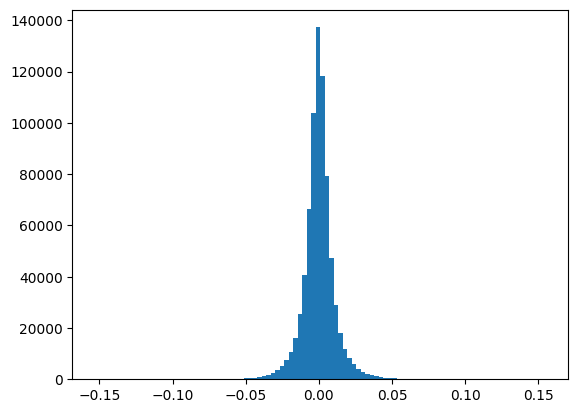

In [51]:
plt.hist(training_responses, bins=100)

#### Detect influential points

I will use Mahalanobis distance, which computes distances from the data's centre and create an oval boundary.

In [52]:
mean_vector = np.mean(training_predictors_df, axis=0)
cov_matrix = np.cov(training_predictors_df, rowvar=False)
inv_cov_matrix = np.linalg.inv(cov_matrix)

In [53]:
mahalanobis_distances = []
for index, row in training_predictors_df.iterrows():
    mahalanobis_distance = scipy.spatial.distance.mahalanobis(row, mean_vector, inv_cov_matrix)
    mahalanobis_distances.append(mahalanobis_distance)

/opt/homebrew/lib/python3.10/site-packages/scipy/spatial/distance.py:1064: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(m)


In [54]:
training_predictors_df['mahalanobis_dist'] = mahalanobis_distances
training_predictors_df.head()

,wt,today,tmwam,dn3sttmwmd,dn1,dn4x1,cftorrrelstd_open_0,liqlog_open_0,llirpnxm_am_1,llirpnxm_dy_12to16,...,tr_nt_0,tr_nt_1,tr_nt_12to16,tr_nt_17to21,tr_nt_1to3,tr_nt_4to6,tr_nt_7to11,tr_pm_1,tr_toxhr_0,mahalanobis_dist
0,0.001426,-0.003854,0.009575,-0.035341,0.017768,-0.025615,-0.031780,0.952881,-0.002913,-0.020135,...,0.000000,0.000000,-0.008639,0.000000,0.000000,0.000000,0.000000,0.0,0.0,17.262321
1,0.001426,-0.002452,0.005502,0.005558,0.005536,0.008619,-0.571585,1.506842,-0.000316,0.002813,...,0.000000,0.000000,0.000000,-0.000889,0.000000,-0.002749,0.000000,0.0,0.0,9.660722
2,0.000103,-0.009077,-0.001128,0.005127,-0.008287,0.015368,-0.659948,-1.757289,-0.000627,-0.020681,...,0.000000,0.000000,0.000000,0.000000,0.110287,0.000000,-0.019189,0.0,0.0,17.561391
3,0.000090,0.000551,0.001066,-0.012716,0.006461,-0.020088,0.466829,-1.882431,0.002429,-0.000644,...,0.000000,0.000000,-0.013316,0.000000,0.000000,0.000000,0.000000,0.0,0.0,14.748704
4,0.000100,0.010167,-0.000366,0.044176,0.001127,0.052270,-1.001732,-1.783126,-0.000593,0.002370,...,-0.005214,0.023126,0.000000,0.000000,0.023126,-0.029055,0.000000,0.0,0.0,17.028080


In [55]:
#TODO: Need discussion
mahal_threshold = 3 # Typical 'mahal_threshold' is 3
outlier_significance_val = .001

In [56]:
training_predictors_df['mahal_p_value'] = 1 - scipy.stats.chi2.cdf(training_predictors_df['mahalanobis_dist'], mahal_threshold)

In [57]:
outlier_condition = (training_predictors_df['mahal_p_value'] < outlier_significance_val)

In [58]:
nonOutlier_indices = training_predictors_df[~outlier_condition].index

In [59]:
temp_col = 'response'
training_predictors_df[temp_col] = training_responses

training_predictors_df = training_predictors_df[~outlier_condition]

training_responses = training_predictors_df[temp_col]
training_predictors_df.drop(temp_col, axis=COL, inplace=True)

In [60]:
training_predictors_df.drop(['mahalanobis_dist', 'mahal_p_value'], axis = COL, inplace=True)
training_predictors_df.reset_index(drop=True)
training_predictors_df.head()

,wt,today,tmwam,dn3sttmwmd,dn1,dn4x1,cftorrrelstd_open_0,liqlog_open_0,llirpnxm_am_1,llirpnxm_dy_12to16,...,tr_md_1,tr_nt_0,tr_nt_1,tr_nt_12to16,tr_nt_17to21,tr_nt_1to3,tr_nt_4to6,tr_nt_7to11,tr_pm_1,tr_toxhr_0
1,0.001426,-0.002452,0.005502,0.005558,0.005536,0.008619,-0.571585,1.506842,-0.000316,0.002813,...,0.0,0.0,0.0,0.000000,-0.000889,0.000000,-0.002749,0.000000,0.0,0.0
3,0.000090,0.000551,0.001066,-0.012716,0.006461,-0.020088,0.466829,-1.882431,0.002429,-0.000644,...,0.0,0.0,0.0,-0.013316,0.000000,0.000000,0.000000,0.000000,0.0,0.0
5,0.000154,-0.006419,-0.002538,-0.003684,-0.008578,-0.004521,-0.930212,-1.363291,0.001795,-0.018409,...,0.0,0.0,0.0,0.000000,0.000000,-0.004651,0.000000,0.000000,0.0,0.0
7,0.001426,0.003193,-0.001535,0.005875,0.002755,0.003176,1.283096,1.022995,-0.000543,0.000075,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.004714,0.0,0.0
9,0.000097,-0.019022,-0.007758,-0.005532,-0.030093,0.000021,-1.004580,-1.810725,0.002585,0.012710,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0


#### Merge features and responses

In [61]:
train_df = pd.concat([training_predictors_df, pd.DataFrame({consts.RESPONSE_NAME: training_responses})], 
                     axis=COL)
test_df = pd.concat([testing_predictors_df, pd.DataFrame({consts.RESPONSE_NAME: testing_responses})], 
                    axis=COL)

### Output

In [62]:
out_train_filename = 'training_data.csv'
out_test_filename = 'testing_data.csv'

In [63]:
train_df.to_csv(consts.CLEANED_DATA_PATH + out_train_filename, index=False)
test_df.to_csv(consts.CLEANED_DATA_PATH + out_test_filename, index=False)

In [64]:
%pip freeze > dependencies.txt

Note: you may need to restart the kernel to use updated packages.


In [65]:
dfs = [pd.read_csv(consts.RAW_DATA_PATH + f"/{f}") for f in files]

In [66]:
dfs[0].head(5)

,eqid,wt,today,tonight,tmwam,dn3sttmwmd,dn1,dn4x1,cftorrrelstd_open_0,liqlog_open_0,...,tr_md_1,tr_nt_0,tr_nt_1,tr_nt_12to16,tr_nt_17to21,tr_nt_1to3,tr_nt_4to6,tr_nt_7to11,tr_pm_1,tr_toxhr_0
0,2,0.001426,-0.003854,0.018082,0.009575,-0.035341,0.017768,-0.025615,-0.031780,0.952881,...,0.0,0.000000,0.000000,-0.008639,0.000000,0.000000,0.000000,0.000000,0.0,0.0
1,24,0.001426,-0.002452,0.005392,0.005502,0.005558,0.005536,0.008619,-0.571585,1.506842,...,0.0,0.000000,0.000000,0.000000,-0.000889,0.000000,-0.002749,0.000000,0.0,0.0
2,31,0.000103,-0.009077,-0.003484,-0.001128,0.005127,-0.008287,0.015368,-0.659948,-1.757289,...,0.0,0.000000,0.000000,0.000000,0.000000,0.110287,0.000000,-0.019189,0.0,0.0
3,39,0.000090,0.000551,0.002358,0.001066,-0.012716,0.006461,-0.020088,0.466829,-1.882431,...,0.0,0.000000,0.000000,-0.013316,0.000000,0.000000,0.000000,0.000000,0.0,0.0
4,41,0.000100,0.010167,-0.005949,-0.000366,0.044176,0.001127,0.052270,-1.001732,-1.783126,...,0.0,-0.005214,0.023126,0.000000,0.000000,0.023126,-0.029055,0.000000,0.0,0.0


In [67]:
dfs[-1].tail(5)

,eqid,wt,today,tonight,tmwam,dn3sttmwmd,dn1,dn4x1,cftorrrelstd_open_0,liqlog_open_0,...,tr_md_1,tr_nt_0,tr_nt_1,tr_nt_12to16,tr_nt_17to21,tr_nt_1to3,tr_nt_4to6,tr_nt_7to11,tr_pm_1,tr_toxhr_0
2974,50539,0.000020,0.009078,0.005219,-0.007753,-0.015235,0.014293,0.045026,-1.674657,-3.448838,...,0.0,-0.000938,0.0,-0.000977,0.0,0.0,0.0,0.018715,-0.004329,0.000000
2975,50542,0.000056,-0.005772,0.004513,-0.011997,-0.012971,-0.008912,-0.026274,-1.622050,-2.419408,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
2976,50545,0.000495,0.002510,-0.001354,0.007585,-0.009322,0.009422,-0.012000,-1.180800,-0.248133,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
2977,50547,0.000145,0.006322,0.010564,0.003794,0.008418,0.025737,0.004534,-1.291330,-1.470772,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.008973
2978,50550,0.000047,0.022402,-0.014477,0.000006,-0.095829,0.033244,-0.072135,-1.674657,-2.606622,...,0.0,0.000000,0.0,0.382959,0.0,0.0,0.0,0.000042,0.000000,0.000000


In [68]:
main_df = pd.concat(dfs)
main_df

,eqid,wt,today,tonight,tmwam,dn3sttmwmd,dn1,dn4x1,cftorrrelstd_open_0,liqlog_open_0,...,tr_md_1,tr_nt_0,tr_nt_1,tr_nt_12to16,tr_nt_17to21,tr_nt_1to3,tr_nt_4to6,tr_nt_7to11,tr_pm_1,tr_toxhr_0
0,2,0.001426,-0.003854,0.018082,0.009575,-0.035341,0.017768,-0.025615,-0.031780,0.952881,...,0.0,0.000000,0.000000,-0.008639,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,24,0.001426,-0.002452,0.005392,0.005502,0.005558,0.005536,0.008619,-0.571585,1.506842,...,0.0,0.000000,0.000000,0.000000,-0.000889,0.000000,-0.002749,0.000000,0.000000,0.000000
2,31,0.000103,-0.009077,-0.003484,-0.001128,0.005127,-0.008287,0.015368,-0.659948,-1.757289,...,0.0,0.000000,0.000000,0.000000,0.000000,0.110287,0.000000,-0.019189,0.000000,0.000000
3,39,0.000090,0.000551,0.002358,0.001066,-0.012716,0.006461,-0.020088,0.466829,-1.882431,...,0.0,0.000000,0.000000,-0.013316,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,41,0.000100,0.010167,-0.005949,-0.000366,0.044176,0.001127,0.052270,-1.001732,-1.783126,...,0.0,-0.005214,0.023126,0.000000,0.000000,0.023126,-0.029055,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2974,50539,0.000020,0.009078,0.005219,-0.007753,-0.015235,0.014293,0.045026,-1.674657,-3.448838,...,0.0,-0.000938,0.000000,-0.000977,0.000000,0.000000,0.000000,0.018715,-0.004329,0.000000
2975,50542,0.000056,-0.005772,0.004513,-0.011997,-0.012971,-0.008912,-0.026274,-1.622050,-2.419408,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2976,50545,0.000495,0.002510,-0.001354,0.007585,-0.009322,0.009422,-0.012000,-1.180800,-0.248133,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2977,50547,0.000145,0.006322,0.010564,0.003794,0.008418,0.025737,0.004534,-1.291330,-1.470772,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008973
